# EMNIST

## Parameters

In [1]:
from pathlib import Path

# Directorio del csv
BASE_DIR = Path('/Users/efraflores/Desktop/EF/Diplo/data/04/pokemon')
# Directorio de las imágenes
IMAGES_DIR = BASE_DIR.joinpath('images')
# Nombre del csv
FILE_NAME = 'pokemon.csv'
# Se va a crear una columna con el nombre de la imagen
PATH_COL = 'filename'
# Si un pokemon tiene dos tipos, se harán dos renglones con cada clase
LABEL_COL = 'class'

## Functions

### Timing and tone

In [2]:
import time
import numpy as np
from IPython.lib.display import Audio

start = time.time()
def time_exp(x):
    #Just print how many minutes and seconds have passed
    minutes, seconds = np.floor(x/60), 60*(x/60-np.floor(x/60))
    print(f"{'{:.0f}'.format(minutes)} minutos con {'{:.2f}'.format(seconds)} segundos")
    
def tone(a=1000, b=700, play_time_seconds=1, framerate=4410):
    #Make a sound! Useful while training models
    t = np.linspace(0, play_time_seconds, framerate*play_time_seconds)*np.pi
    return Audio(np.sin(a*t)+np.sin(b*t), rate=framerate, autoplay=True)

### Show pokemon from DataFrame

In [3]:
from PIL import Image

def show_pokemon(pokemon='pikachu', filepath='images', ext='png'):
    img = Image.open(Path(filepath).joinpath(f'{pokemon}.{ext}'))
    return img

### Blur image

In [4]:
#!pip install opencv-python
import cv2
def blur(img):
    return cv2.GaussianBlur(np.asarray(img), ksize=(5,5), sigmaX=0)

### ImageDataGenerator from DataFrame

In [5]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def images_from_df(data, seed=22, **kwargs):
    
    df = data.copy()
    X_train, X_test = train_test_split(df, train_size=0.8, random_state=seed)

    train_gen = ImageDataGenerator(rescale=1./255,
                                preprocessing_function=blur,
                                shear_range=0.2,
                                # zoom_range=0.1,
                                # horizontal_flip=True,
                                # rotation_range=15
                                )

    training_set = train_gen.flow_from_dataframe(dataframe=X_train, **kwargs)
    testing_set = ImageDataGenerator(rescale=1./255).flow_from_dataframe(dataframe=X_test, **kwargs)
    
    print('\n These are the classes:\n',training_set.class_indices)
    return training_set, testing_set

### CNN builder

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, AveragePooling2D, Dropout, LeakyReLU

def cnn_builder(train_set, layer_filters, cnn_activ, layer_units, seq_activ):
    n_classes = len(train_set.class_indices)

    model = Sequential()
    model.add(Conv2D(filters=n_classes*50, kernel_size=10, input_shape=train_set.image_shape, activation='relu'))
    model.add(MaxPool2D(10))
    for filters,activ in zip(layer_filters, cnn_activ):
        model.add(Conv2D(filters, 3, activation=activ))
        model.add(AveragePooling2D(3))
    
    model.add(Dropout(0.1))
    model.add(Flatten())
    
    for units,activa in zip(layer_units, seq_activ):
        model.add(Dense(units, activa))
    
    last_layer,last_activ = (1,'sigmoid') if n_classes<=2 else (n_classes,'softmax')
    model.add(Dense(last_layer, last_activ))
    
    print(model.summary())
    return model

### Plot metrics

In [7]:
import matplotlib.pyplot as plt

def plot_metrics(training_history,metrics=['accuracy','loss']):
    #Show the trend of every metrics provided after training
    for metric in metrics:
        trend = training_history.history[metric]
        plt.figure()
        plt.plot(range(len(trend)), trend, 'r', label=f'Training {metric}')
        plt.title(f'Training {metric}')
    plt.show()

### Confussion Matrix CNN

In [8]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def cm_keras(test_gen, fit_model):
    y_real = test_gen.classes
    y_predicted = [np.argmax(x).reshape(-1,)[0] for x in fit_model.predict(test_gen)]

    cm = pd.DataFrame(confusion_matrix(y_true=y_real, y_pred=y_predicted),
                    index=test_gen.class_indices,
                    columns=test_gen.class_indices).replace({0:np.nan})
    print('Accuracy de {:.2%}'.format(np.asarray(cm).trace()/len(y_real)))
     
    size = int(len(test_gen.class_indices)/2)
    fig, ax = plt.subplots(figsize=(size,size))
    sns.heatmap(pd.DataFrame([cm[col]/cm.sum(axis=1) for col in cm.columns],
                            index=test_gen.class_indices,
                            columns=test_gen.class_indices).T, 
                annot = True,
                fmt = '.0%',
                cmap = 'Blues',
                linewidths = 0.5, 
                ax = ax)
    plt.show()
    return cm

## Data Wrangling

### Import

In [9]:
import pandas as pd

# Importar csv como DataFrame
df = pd.read_csv(BASE_DIR.joinpath(FILE_NAME))
df.sample()

,Name,Type1,Type2
743,rockruff,Rock,NaN


### All images in .jpg

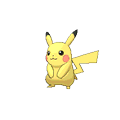

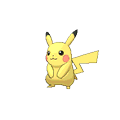

In [10]:
png = show_pokemon(filepath=IMAGES_DIR).convert('RGBA')
png.load()
jpg = Image.new("RGB", png.size, (255, 255, 255))
jpg.paste(png, mask=png.split()[3])
display(png, jpg)

In [11]:
import shutil

BASE_DIR.joinpath('images_correct').mkdir(exist_ok=True)
for x in df['Name']:
    if IMAGES_DIR.joinpath(f'{x}.jpg').exists():
        shutil.copy(IMAGES_DIR.joinpath(f'{x}.jpg'),BASE_DIR.joinpath('images_correct',f'{x}.jpg'))
    else:
        png = Image.open(IMAGES_DIR.joinpath(f'{x}.png')).convert('RGBA')
        png.load()
        background = Image.new("RGB", png.size, (255, 255, 255))
        background.paste(png, mask=png.split()[3])
        background.save(BASE_DIR.joinpath('images_correct',f'{x}.jpg'), 'JPEG', quality=100)
IMAGES_DIR = BASE_DIR.joinpath('images_correct')

### Filename column

In [12]:
# Crear la columna, hay archivos png y jpg
df[PATH_COL] = df['Name'].apply(lambda x: f'{x}.jpg')
df.set_index('Name', inplace=True)
df.sample()

,Type1,Type2,filename
Name,,,
bronzor,Steel,Psychic,bronzor.jpg


### Just one column-label

In [13]:
# Si tiene dos tipos, se agrega otro renglón con el segundo tipo
df = df.melt(id_vars=PATH_COL, value_vars=['Type1','Type2'], ignore_index=False)
# Se ajustan columnas
df = df.rename({'value':LABEL_COL}, axis=1).drop('variable', 1).dropna()
df.sample()

,filename,class
Name,,
blitzle,blitzle.jpg,Electric


In [14]:
# df = df[['filename','Type1']].rename({'Type1':'class'}, axis=1)
# df.sample()

### Image Data Generator

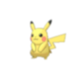

In [15]:
Image.fromarray(blur(jpg)).resize((80,80))

In [16]:
train, test = images_from_df(df, directory=IMAGES_DIR, target_size=(80,80), batch_size=32, seed=22)

Found 971 validated image filenames belonging to 18 classes.
Found 243 validated image filenames belonging to 18 classes.

 These are the classes:
 {'Bug': 0, 'Dark': 1, 'Dragon': 2, 'Electric': 3, 'Fairy': 4, 'Fighting': 5, 'Fire': 6, 'Flying': 7, 'Ghost': 8, 'Grass': 9, 'Ground': 10, 'Ice': 11, 'Normal': 12, 'Poison': 13, 'Psychic': 14, 'Rock': 15, 'Steel': 16, 'Water': 17}


## Model

In [17]:
model = cnn_builder(train,[],[],[50],['relu'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 71, 71, 900)       270900    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 7, 7, 900)         0         
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 900)         0         
_________________________________________________________________
flatten (Flatten)            (None, 44100)             0         
_________________________________________________________________
dense (Dense)                (None, 50)                2205050   
_________________________________________________________________
dense_1 (Dense)              (None, 18)                918       
Total params: 2,476,868
Trainable params: 2,476,868
Non-trainable params: 0
______________________________________________

2021-08-08 08:04:04.729737: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Compile

In [18]:
from tensorflow.keras.optimizers import Adam
opt = Adam(learning_rate=1e-2)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics='accuracy')

### Callbacks

#### Early Stopping

In [19]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=20)

#### Checkpoints

In [20]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(BASE_DIR.joinpath('models/model_{val_accuracy:.3f}.h5'),
                            save_best_only=True,
                            save_weights_only=False,
                            monitor='val_accuracy')

### Training

#### Fit

In [21]:
train_history = model.fit(train, validation_data=test, epochs=10, callbacks=[early_stopping, checkpoint])

2021-08-08 08:04:05.012796: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
31/31 [==============================] - 45s 1s/step - loss: 18.3335 - accuracy: 0.0793 - val_loss: 2.8826 - val_accuracy: 0.0782
Epoch 2/10
31/31 [==============================] - 45s 1s/step - loss: 2.8406 - accuracy: 0.0927 - val_loss: 2.8827 - val_accuracy: 0.0782
Epoch 3/10
31/31 [==============================] - 48s 2s/step - loss: 2.8186 - accuracy: 0.1020 - val_loss: 2.8900 - val_accuracy: 0.1235
Epoch 4/10
31/31 [==============================] - 48s 2s/step - loss: 2.8134 - accuracy: 0.1040 - val_loss: 2.8961 - val_accuracy: 0.1235
Epoch 5/10
31/31 [==============================] - 44s 1s/step - loss: 2.8140 - accuracy: 0.1040 - val_loss: 2.8926 - val_accuracy: 0.1235
Epoch 6/10
31/31 [==============================] - 40s 1s/step - loss: 2.8133 - accuracy: 0.1040 - val_loss: 2.8909 - val_accuracy: 0.1235
Epoch 7/10
31/31 [==============================] - 38s 1s/step - loss: 2.8127 - accuracy: 0.1040 - val_loss: 2.8875 - val_accuracy: 0.1235
Epoch 8/10
31/31 [=

#### Metrics

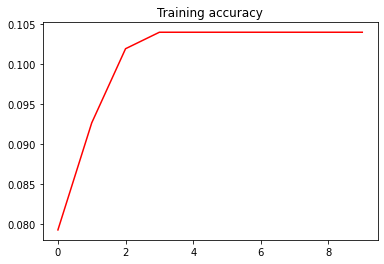

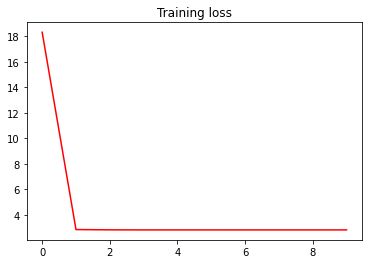

In [22]:
plot_metrics(train_history)

### Confussion Matrix

Accuracy de nan%


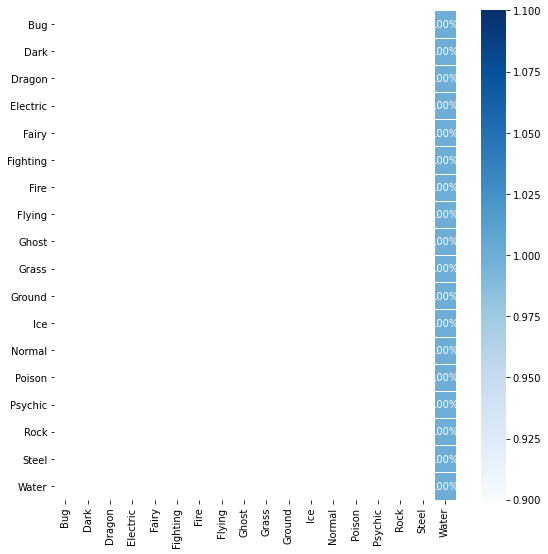

In [23]:
keras_cm = cm_keras(test,model)

### Export

In [46]:
import re
from keras.models import load_model

max_acc = max([str(x)[-8:-3] for x in BASE_DIR.joinpath('models').glob('**/*') if x.is_file() and str(x)[-8:-3]!='DS_St'])
path_model = [str(x) for x in BASE_DIR.joinpath('models').glob('**/*') if re.search(max_acc,str(x))!=None][0]
model = load_model(path_model)
model

In [47]:
model.save(BASE_DIR.joinpath('pokemon_model.h5'))

## End

In [25]:
time_exp(time.time() - start)
tone()

7 minutos con 13.03 segundos
